# EE 267 Project coding by Anika Zaman, Id: 015955082

In [1]:
#Code by Anika Zaman
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from glob import glob
 
from sklearn.model_selection import train_test_split
from sklearn import metrics
 
import cv2
import gc
import os
 
import tensorflow as tf
from tensorflow import keras
from keras import layers
 
import warnings
warnings.filterwarnings('ignore')
import tensorflow.compat.v1 as tf

In [2]:
path = 'lung-and-colon-cancer-histopathological-images\lung_colon_image_set\lung_colon_image_sets'
classes = os.listdir(path)
classes

['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc']

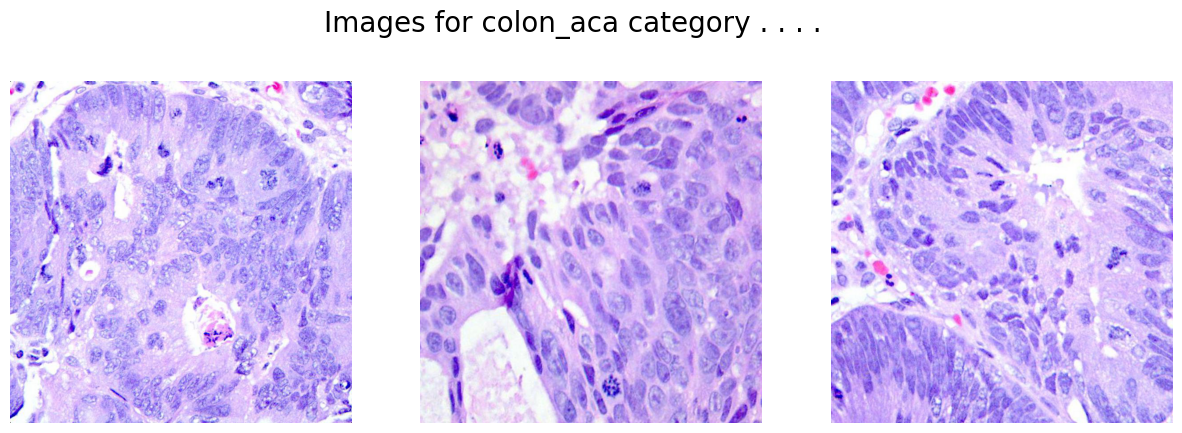

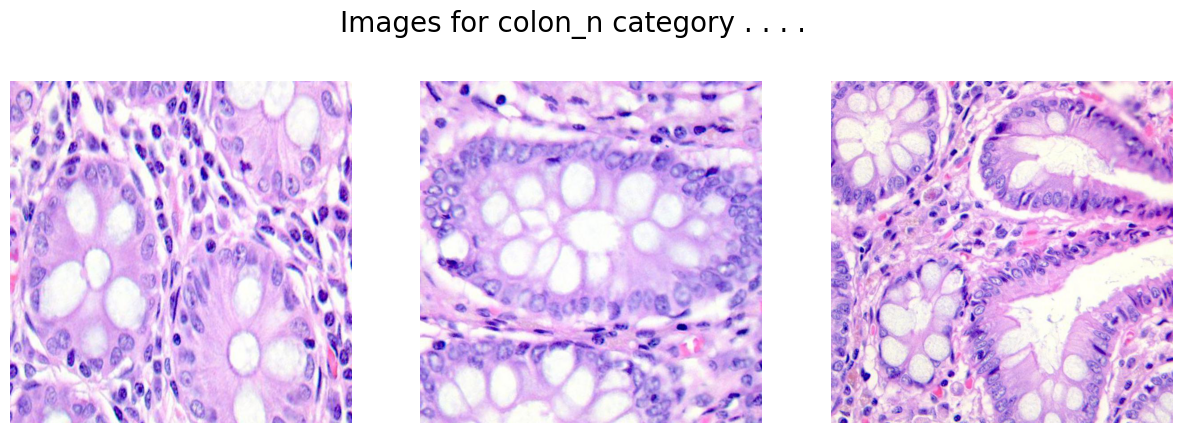

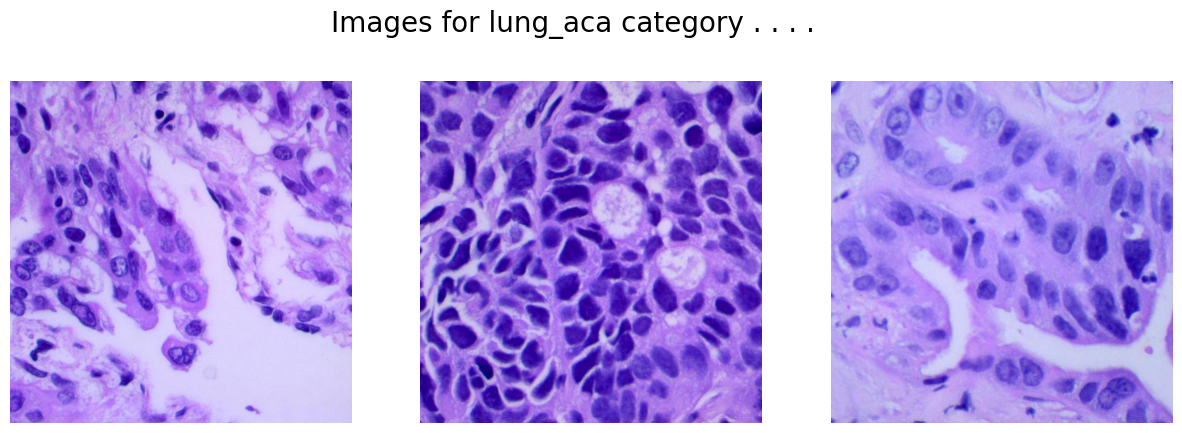

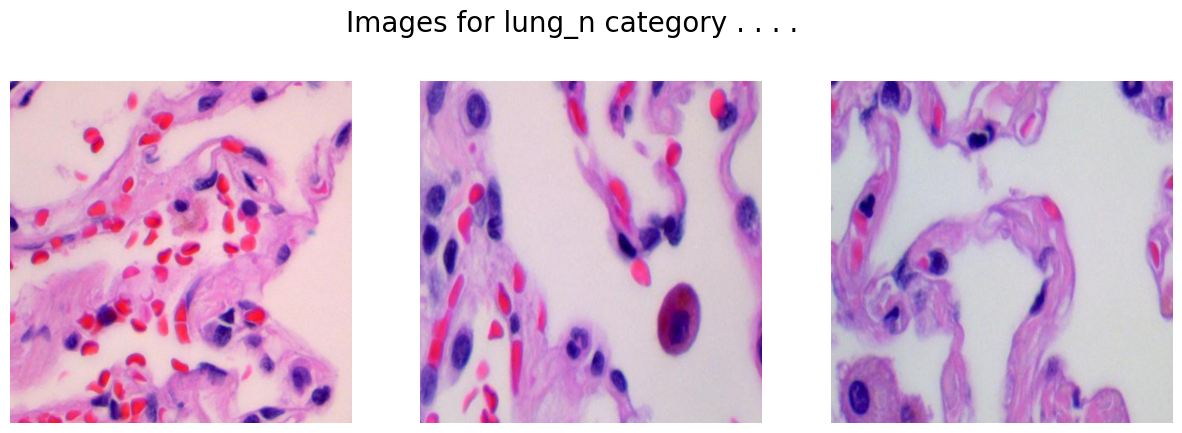

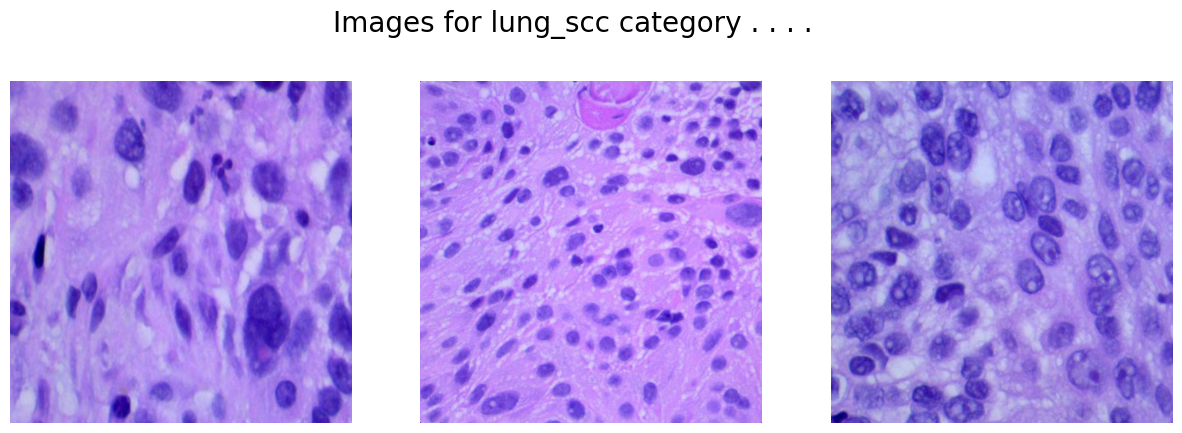

In [3]:
path = 'lung-and-colon-cancer-histopathological-images\lung_colon_image_set\lung_colon_image_sets'
 
for cat in classes:
    image_dir = f'{path}/{cat}'
    images = os.listdir(image_dir)
 
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Images for {cat} category . . . .', fontsize=20)
 
    for i in range(3):
        k = np.random.randint(0, len(images))
        img = np.array(Image.open(f'{path}/{cat}/{images[k]}'))
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()

In [4]:
IMG_SIZE = 224
SPLIT = 0.2
EPOCHS = 10
BATCH_SIZE = 32 #changed from 64 to 32

In [5]:
from glob import glob  
# Initialize X and Y
X = []
Y = []
for i, cat in enumerate(classes):
    images = glob(f'{path}/{cat}/*.jpeg')  # Use glob function explicitly

    for image in images:
        img = cv2.imread(image)
        X.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
        Y.append(i)

# Convert lists to arrays
X = np.asarray(X)
Y = np.asarray(Y)

# Shuffle the data
indices = np.arange(len(X))
np.random.shuffle(indices)

# Select the first 5000 shuffled samples
num_samples = 5000
X_subset = X[indices[:num_samples]]
Y_subset = Y[indices[:num_samples]]

# Convert Y_subset to one-hot encoding
one_hot_encoded_Y_subset = pd.get_dummies(Y_subset).values

In [6]:
X_train, X_val, Y_train, Y_val = train_test_split(X_subset, one_hot_encoded_Y_subset,
                                                  test_size = SPLIT,
                                                  random_state = 2022)
print(X_train.shape, X_val.shape)

(4000, 224, 224, 3) (1000, 224, 224, 3)


In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models

IMG_SIZE = 224  # Change this to your desired image size

import os
import cv2
import numpy as np
from glob import glob
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Create a new DenseNet121 model without pre-trained weights
base_model = DenseNet121(weights=None, include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(5, activation='softmax'))  # Adjust based on the number of classes

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 7333445 (27.97 MB)
Trainable params: 7249797 (27.66 MB)
Non-trainable params: 83648 (326.75 KB)
____________

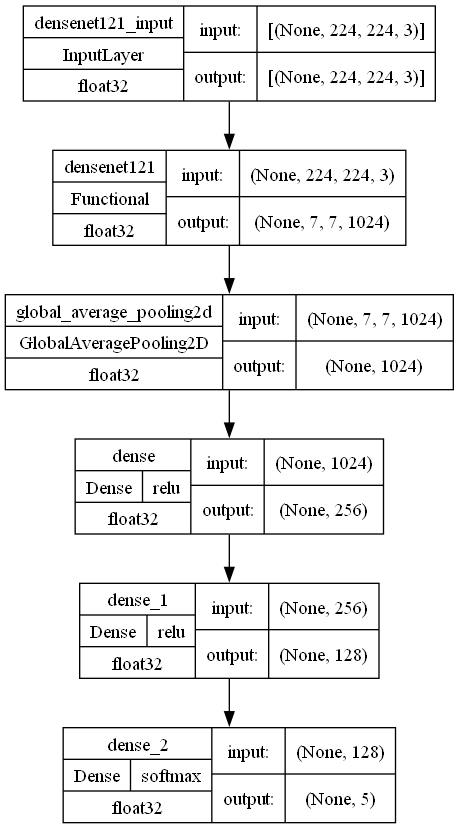

In [9]:
keras.utils.plot_model(
    model,
    show_shapes = True,
    show_dtype = True,
    show_layer_activations = True
)

In [10]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
 
 
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') > 0.99:
            print('\n Validation accuracy has reached upto \
                      90% so, stopping further training.')
            self.model.stop_training = True
 
 
es = EarlyStopping(patience=3,
                   monitor='val_accuracy',
                   restore_best_weights=True)
 
lr = ReduceLROnPlateau(monitor='val_loss',
                       patience=2,
                       factor=0.5,
                       verbose=1)

In [11]:
# Import the necessary modules
import tensorflow.compat.v1 as tf
from tensorflow.compat.v1.keras.optimizers import Adam  # Assuming you're using Adam optimizer

# Compile the model
model.compile(optimizer=Adam(),  # Use the Adam optimizer (or choose another)
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# Now you can proceed with training
history = model.fit(X_train, Y_train,
                    validation_data=(X_val, Y_val),
                    batch_size= 32,
                    epochs=EPOCHS,
                    verbose=1,
                    callbacks=[es, lr, myCallback()])


Epoch 1/10


125/125 [==============================] - 1145s 9s/step - loss: 0.4583 - accuracy: 0.8230 - val_loss: 516.4919 - val_accuracy: 0.2020 - lr: 0.0010
Epoch 2/10
125/125 [==============================] - 1095s 9s/step - loss: 0.3058 - accuracy: 0.8848 - val_loss: 316.3053 - val_accuracy: 0.2020 - lr: 0.0010
Epoch 3/10
125/125 [==============================] - 1091s 9s/step - loss: 0.2529 - accuracy: 0.9007 - val_loss: 110.6837 - val_accuracy: 0.2020 - lr: 0.0010
Epoch 4/10
125/125 [==============================] - 1100s 9s/step - loss: 0.2431 - accuracy: 0.9035 - val_loss: 11.0086 - val_accuracy: 0.4700 - lr: 0.0010
Epoch 5/10
125/125 [==============================] - 1269s 10s/step - loss: 0.2142 - accuracy: 0.9172 - val_loss: 1.6761 - val_accuracy: 0.6400 - lr: 0.0010
Epoch 6/10
125/125 [==============================] - 1350s 11s/step - loss: 0.2022 - accuracy: 0.9227 - val_loss: 7.7394 - val_accuracy: 0.2830 - lr: 0.0010
Epoch 7/10
125/125 [===========================

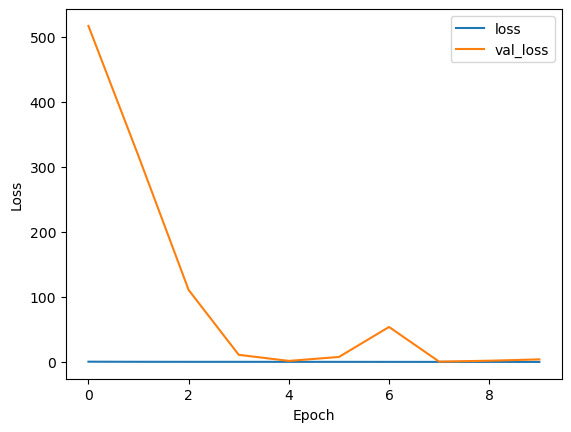

In [12]:
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.show()

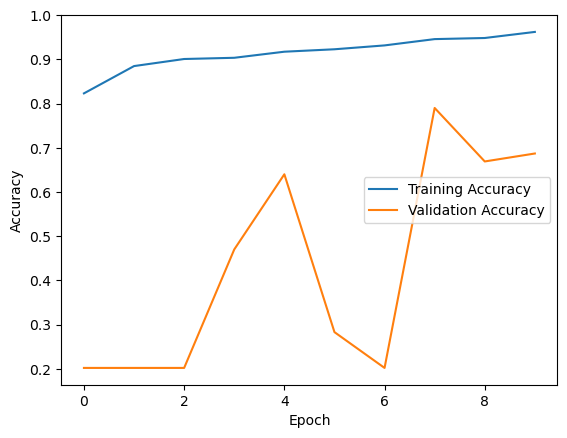

In [13]:
# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [14]:
Y_pred = model.predict(X_val)
Y_val = np.argmax(Y_val, axis=1)
Y_pred = np.argmax(Y_pred, axis=1)

32/32 [==============================] - 77s 2s/step


In [15]:
metrics.confusion_matrix(Y_val, Y_pred)

array([[  0, 194,   0,   0,   0],
       [  0, 202,   0,   0,   0],
       [  1,   3, 198,   0,   3],
       [  0,  29,  13, 159,   0],
       [  2,   5,  63,   0, 128]], dtype=int64)

In [16]:
print(metrics.classification_report(Y_val, Y_pred,
                                    target_names=classes))

              precision    recall  f1-score   support

   colon_aca       0.00      0.00      0.00       194
     colon_n       0.47      1.00      0.64       202
    lung_aca       0.72      0.97      0.83       205
      lung_n       1.00      0.79      0.88       201
    lung_scc       0.98      0.65      0.78       198

    accuracy                           0.69      1000
   macro avg       0.63      0.68      0.62      1000
weighted avg       0.64      0.69      0.63      1000



In [17]:
x = (history.history['accuracy'])
print(x)
print(x[9])

[0.8230000138282776, 0.8847500085830688, 0.9007499814033508, 0.9035000205039978, 0.9172499775886536, 0.9227499961853027, 0.9315000176429749, 0.9457499980926514, 0.9482499957084656, 0.9620000123977661]
0.9620000123977661


In [18]:
y = (history.history['loss'])
print(y)
print(y[9])

[0.4582795798778534, 0.3057608902454376, 0.252858430147171, 0.24313735961914062, 0.21416489779949188, 0.20220988988876343, 0.17341084778308868, 0.13990332186222076, 0.13523545861244202, 0.10477758198976517]
0.10477758198976517


In [19]:
import pandas as pd

# Example parameter data
parameters = {'accuracy': x[9], 'loss': y[9]}

# Create a DataFrame
df = pd.DataFrame([parameters])

# Specify the CSV file path
csv_file_path = 'EE267_denseNet_parameters5000.csv'

# Save DataFrame to CSV
df.to_csv(csv_file_path, index=False)

print(f'Parameter data saved to {csv_file_path}')

Parameter data saved to EE267_denseNet_parameters5000.csv
